# BigMart Sales Prediction
#### In this notebook we will tackle the BigMart Sales Prediction practice problem from Analytics Vidhya

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
# import math
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from scipy.stats import mode
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

from sklearn.model_selection import RandomizedSearchCV
from time import time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# !pip install pdpbox

#### Read the data

In [2]:
df_raw = pd.read_csv("../input/Train.csv")
df_raw.head

FileNotFoundError: File b'../input/Train.csv' does not exist

In [4]:
df_test = pd.read_csv("../input/Test.csv")
alldata = pd.concat([df_raw, df_test],ignore_index=True)
alldata.shape

(14204, 12)

# Preprocess data

In [5]:
alldata.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
dtype: object

In [6]:
le = LabelEncoder()
alldata['Outlet_Size'] = le.fit_transform(alldata['Outlet_Size'].astype(str))

#### Impute missing values

In [7]:
def impute_na(data):

    #Determing the mode for each
    outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )

    #Get a boolean variable specifying missing Item_Weight values
    isMissing = data['Outlet_Size'].isnull() 

    #Impute data and check #missing values before and after imputation to confirm
    print('\nOrignal #missing Outlet_Size: %d'% sum(isMissing))
    data.loc[isMissing,'Outlet_Size'] = data.loc[isMissing,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
    print('Final #missing Outlet_Size: %d'% sum(data['Outlet_Size'].isnull()))
    
    item_avg_weight = data.pivot_table(values=['Item_Weight'], index=['Item_Identifier'], dropna=False, fill_value=0)

    #Get a boolean variable specifying missing Item_Weight values
    isMissing = data['Item_Weight'].isnull() 

    #Impute data and check #missing values before and after imputation to confirm
    print('Orignal #missing Item_Weight: %d'% sum(isMissing))
    data.loc[isMissing,'Item_Weight'] = data.loc[isMissing,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
    print('Final #missing Item_Weight: %d'% sum(data['Item_Weight'].isnull()))

impute_na(alldata)


Orignal #missing Outlet_Size: 0
Final #missing Outlet_Size: 0
Orignal #missing Item_Weight: 2439
Final #missing Item_Weight: 0


#### Fix rows with visibility zero and update categories of Fat Content

In [8]:
def preproc(data):
    visibility_avg = data.pivot_table(values='Item_Visibility', index=['Outlet_Identifier'], aggfunc=np.mean)
    # visibility_avg
    #Impute 0 values with mean visibility of that product:
    isMissing = (data['Item_Visibility'] == 0)
    print('Number of 0 values initially: %d'%sum(isMissing))
    data.loc[isMissing,'Item_Visibility'] = data.loc[isMissing,'Outlet_Identifier'].apply(
        lambda x: visibility_avg.loc[x])
    print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

    #Years:
    data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

    #Change categories of low fat:
    print('Original Categories:')
    print(data['Item_Fat_Content'].value_counts())
    print('\nModified Categories:')
    data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
    'reg':'Regular',
    'low fat':'Low Fat'})
    print(data['Item_Fat_Content'].value_counts())

preproc(alldata)

Number of 0 values initially: 879
Number of 0 values after modification: 0
Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


# Exploratory Data Analysis

### Choice of target variable
#### As Item_Outlet_Sales can easily be derived from Item_MRP the relation is obvious. We need to remove this obvious relation from the analysis so as to explore the true unexplained relationship between predictors and sales. In order to do this we will introduce volume of sales as a new variable and make it the target. And after building model and predicting the volume we can easily derive sales.

In [9]:
train=alldata[alldata['Item_Outlet_Sales'].notnull()]

In [10]:
train[train['Item_MRP'] ==0]

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Outlet_Years


In [11]:
train['Item_Outlet_Vol'] = train['Item_Outlet_Sales'] / train['Item_MRP']

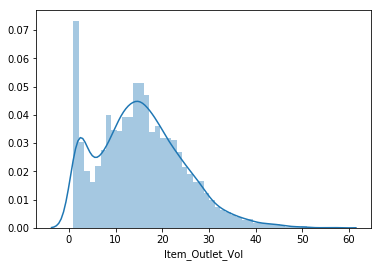

In [12]:
sns.distplot(train['Item_Outlet_Vol'])

#### The target variable is not having a normal distribution - instead this indicates a bimodal distribution. Let's try log transformation

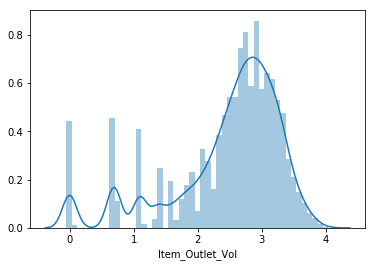

In [13]:
sns.distplot(np.log(train['Item_Outlet_Vol']))

#### Still we have a non normal distribution. We can't use any parametric tests here.

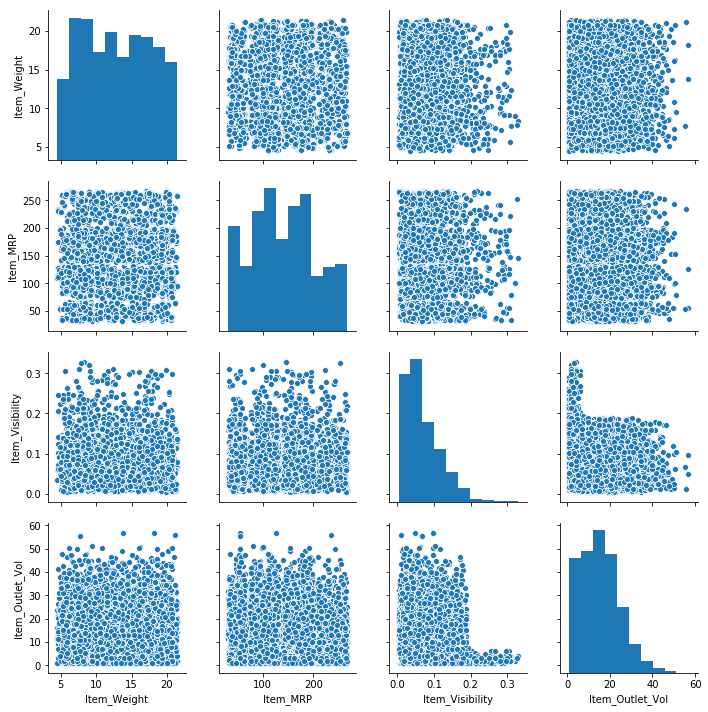

In [14]:
sns.pairplot(train[['Item_Weight','Item_MRP', 'Item_Visibility', 'Item_Outlet_Vol']])

#### No trend visible in the numeric variables. Let's turn to categorical variables.

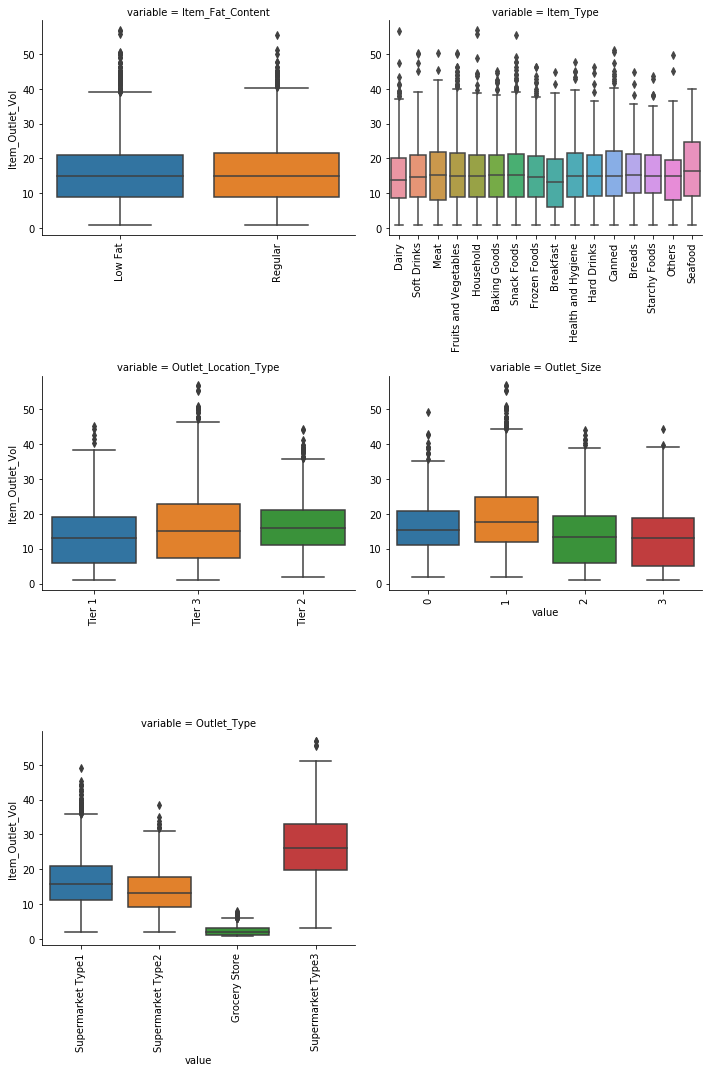

In [15]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if ((train.dtypes[f] == 'object') & (f.find("Identifier") == -1))]

p = pd.melt(train, id_vars='Item_Outlet_Vol', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value','Item_Outlet_Vol')
g

#### Only the Outlet typs shows noticiable variance. We will use the Outlet as predictor as there are only few of them and the above trend seems promising. Item types overall seems to be pretty stable. Let's dig deeper and see Item types by store type.

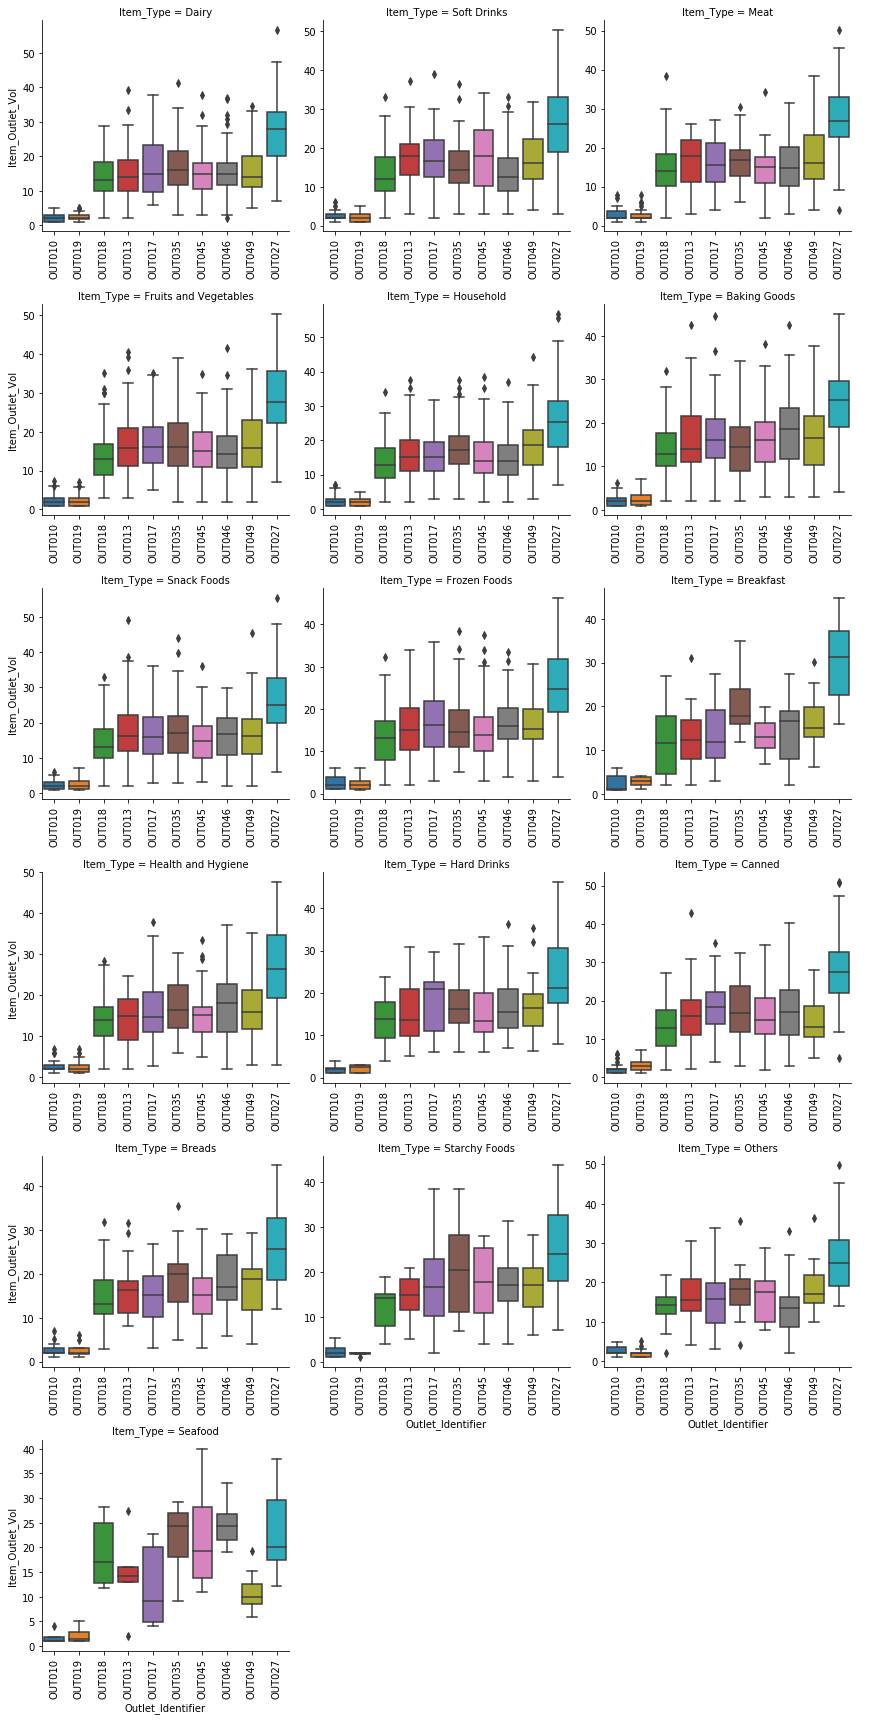

In [16]:
def boxplot_2(x,y,**kwargs):
            sns.boxplot(x=x,y=y,
                        order=["OUT010","OUT019", "OUT018","OUT013","OUT017","OUT035",
                               "OUT045","OUT046","OUT049","OUT027"])
            x = plt.xticks(rotation=90)

g = sns.FacetGrid(data=train, col="Item_Type", col_wrap=3, sharex=False, sharey=False, 
                  margin_titles=True, height=4)

g.map(boxplot_2, 'Outlet_Identifier', 'Item_Outlet_Vol')
g.add_legend()

#### We can see that Sales volume by Item types varies when we condition on Outlet type.

# Model Building

In [17]:
alldata['Outlet_Years'] = alldata['Outlet_Years'].astype('category').cat.as_ordered()
alldata['Outlet'] = alldata['Outlet_Identifier'].astype('category').cat.as_ordered()
alldata['Item_Type'] = alldata['Item_Type'].astype('category').cat.as_ordered()

In [18]:
alldata = pd.get_dummies(alldata, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type','Outlet_Years','Outlet'])
alldata = alldata.drop(['Outlet_Establishment_Year'] ,axis=1)

In [19]:
alldata.dtypes

Item_Identifier                     object
Item_MRP                           float64
Item_Outlet_Sales                  float64
Item_Visibility                    float64
Item_Weight                        float64
Outlet_Identifier                   object
Item_Fat_Content_Low Fat             uint8
Item_Fat_Content_Regular             uint8
Outlet_Location_Type_Tier 1          uint8
Outlet_Location_Type_Tier 2          uint8
Outlet_Location_Type_Tier 3          uint8
Outlet_Size_0                        uint8
Outlet_Size_1                        uint8
Outlet_Size_2                        uint8
Outlet_Size_3                        uint8
Outlet_Type_Grocery Store            uint8
Outlet_Type_Supermarket Type1        uint8
Outlet_Type_Supermarket Type2        uint8
Outlet_Type_Supermarket Type3        uint8
Item_Type_Baking Goods               uint8
Item_Type_Breads                     uint8
Item_Type_Breakfast                  uint8
Item_Type_Canned                     uint8
Item_Type_D

In [20]:
train=alldata[alldata['Item_Outlet_Sales'].notnull()]
test=alldata[alldata['Item_Outlet_Sales'].isnull()]

train.drop(["Outlet_Identifier","Item_Identifier"], axis=1, inplace=True)
test.drop("Item_Outlet_Sales", axis=1, inplace=True)
train.shape,test.shape

((8523, 52), (5681, 53))

In [21]:
train['Item_Outlet_Vol'] = train['Item_Outlet_Sales'] / train['Item_MRP']
train.drop("Item_Outlet_Sales", axis=1, inplace=True)

In [22]:
id_columns = ["Outlet_Identifier", "Item_Identifier"]
target = 'Item_Outlet_Vol'
predictors = [x for x in train.columns if x not in [target]+id_columns]
predictors

['Item_MRP',
 'Item_Visibility',
 'Item_Weight',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Size_0',
 'Outlet_Size_1',
 'Outlet_Size_2',
 'Outlet_Size_3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Years_4',
 'Outlet_Years_6',
 'Outlet_Years_9',
 'Outlet_Years_11',
 'Outlet_Years_14',
 'Outlet_Years_15',
 'Outlet_Years_16',
 'Outlet_Years_26',
 'Outlet_Years_28',
 'Outlet_OUT010

In [23]:
X = train[predictors]
y = train[target]

In [24]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [25]:
seed = 42

### Ridge Regression

In [26]:
model_ridge = Ridge()

In [27]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

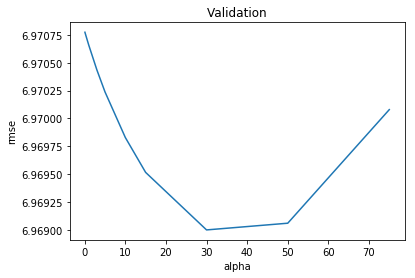

In [28]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [29]:
cv_ridge.min()

6.96899852306929

In [30]:
def make_submission(model, X_train, y_train, X_test, file_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test[predictors]) * test['Item_MRP']
#     print(np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    df_submit = pd.DataFrame()
    df_submit = X_test[['Item_Identifier','Outlet_Identifier']]
    df_submit['Item_Outlet_Sales'] = pd.Series(preds)
    df_submit.to_csv(file_name, index=False)

In [31]:
model_Ridge = Ridge(alpha=30)

make_submission(model_Ridge, X, y, test, "ridge_predictions.csv")

**LB Score 1151.80**

### Lasso

In [32]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], random_state=seed).fit(X,y)

In [33]:
rmse_cv(model_lasso).mean()

6.98101520055481

In [34]:
make_submission(model_lasso, X, y, test, "lasso_predictions.csv")

**LB Score 1151.57**

In [35]:
coef = pd.Series(model_lasso.coef_, index = predictors)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 35 variables and eliminated the other 16 variables


In [36]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [37]:
coef

Item_MRP                           1.779765e-03
Item_Visibility                    0.000000e+00
Item_Weight                       -1.094810e-02
Item_Fat_Content_Low Fat          -2.313768e-01
Item_Fat_Content_Regular           1.006225e-13
Outlet_Location_Type_Tier 1        0.000000e+00
Outlet_Location_Type_Tier 2        4.642537e-01
Outlet_Location_Type_Tier 3       -1.815992e-01
Outlet_Size_0                     -0.000000e+00
Outlet_Size_1                      4.063053e-01
Outlet_Size_2                      0.000000e+00
Outlet_Size_3                     -0.000000e+00
Outlet_Type_Grocery Store         -1.362929e+01
Outlet_Type_Supermarket Type1      3.305923e-04
Outlet_Type_Supermarket Type2     -2.508592e+00
Outlet_Type_Supermarket Type3      1.002286e+01
Item_Type_Baking Goods            -3.821363e-02
Item_Type_Breads                   2.182216e-01
Item_Type_Breakfast               -4.364107e-01
Item_Type_Canned                   2.250340e-01
Item_Type_Dairy                   -4.108

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

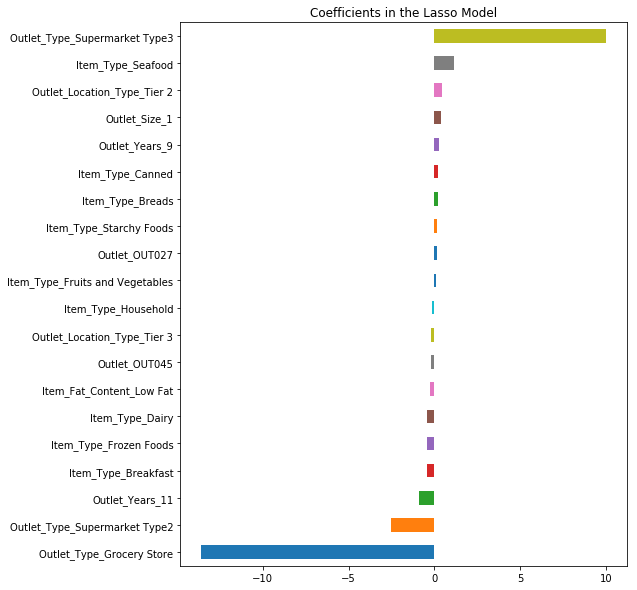

In [38]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

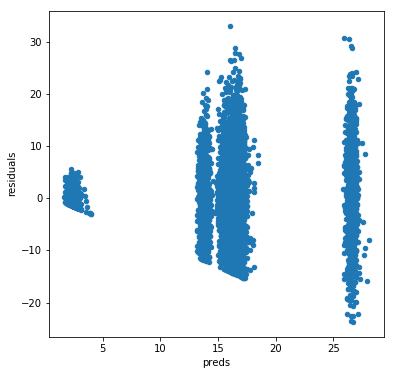

In [39]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### XGBoost

###### Let's try XGBoost - the hyper parameters are found by running RandomizedSearchCV

In [40]:
model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.1, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=30, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [41]:
rmse_cv(model_xgb).mean()

6.962482190023806

In [42]:
make_submission(model_xgb, X, y, test, "xgb_predictions.csv")

**LB Score 1151.03**

In [43]:
fi = pd.DataFrame({'cols':X.columns, 'imp':model_xgb.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi

,cols,imp
13,Outlet_Type_Supermarket Type1,0.222512
12,Outlet_Type_Grocery Store,0.194802
40,Outlet_Years_28,0.136539
15,Outlet_Type_Supermarket Type3,0.125852
37,Outlet_Years_15,0.101276
45,Outlet_OUT019,0.090594
46,Outlet_OUT027,0.050090
41,Outlet_OUT010,0.038610
16,Item_Type_Baking Goods,0.004067
9,Outlet_Size_1,0.003636


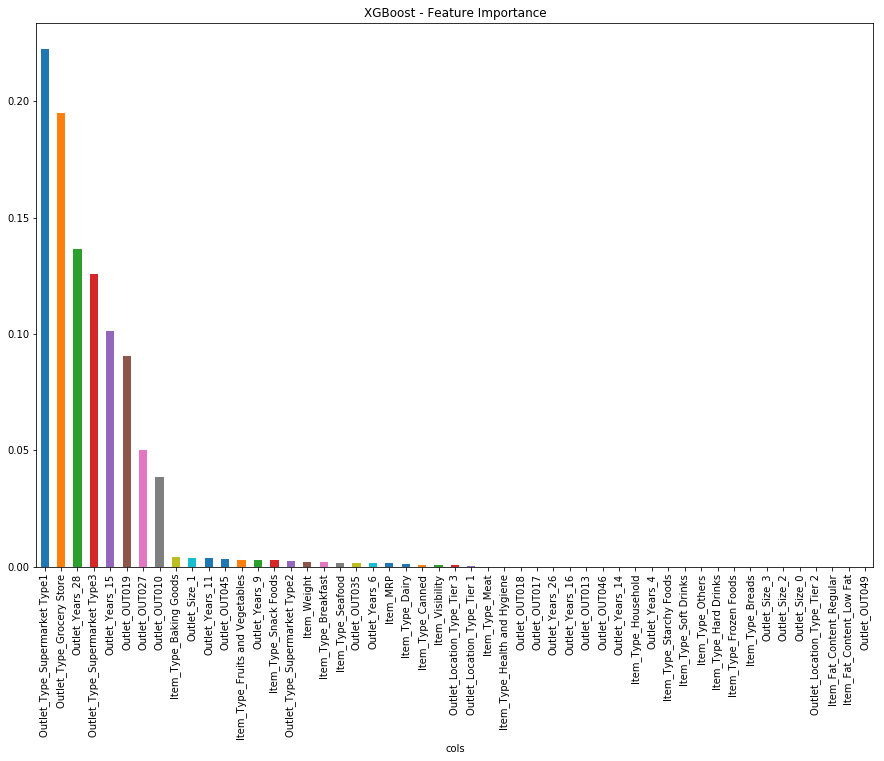

In [44]:
fi[:].plot('cols', 'imp', figsize=(15,10), xticks=fi.index, legend=False, 
           kind='bar',title="XGBoost - Feature Importance")

### Random Forest

###### Let's try RandomForest - the hyper parameters are found by running RandomizedSearchCV

In [45]:
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=40, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [46]:
rmse_cv(model_rf).mean()

6.964214859209295

In [47]:
make_submission(model_rf, X, y, test, "rf_predictions.csv")

**LB Score 1150.89**

In [48]:
fi = pd.DataFrame({'cols':X.columns, 'imp':model_rf.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [49]:
fi

,cols,imp
12,Outlet_Type_Grocery Store,0.206109
46,Outlet_OUT027,0.119874
15,Outlet_Type_Supermarket Type3,0.116997
41,Outlet_OUT010,0.075785
45,Outlet_OUT019,0.072268
37,Outlet_Years_15,0.069549
40,Outlet_Years_28,0.066614
13,Outlet_Type_Supermarket Type1,0.066108
9,Outlet_Size_1,0.030878
1,Item_Visibility,0.017154


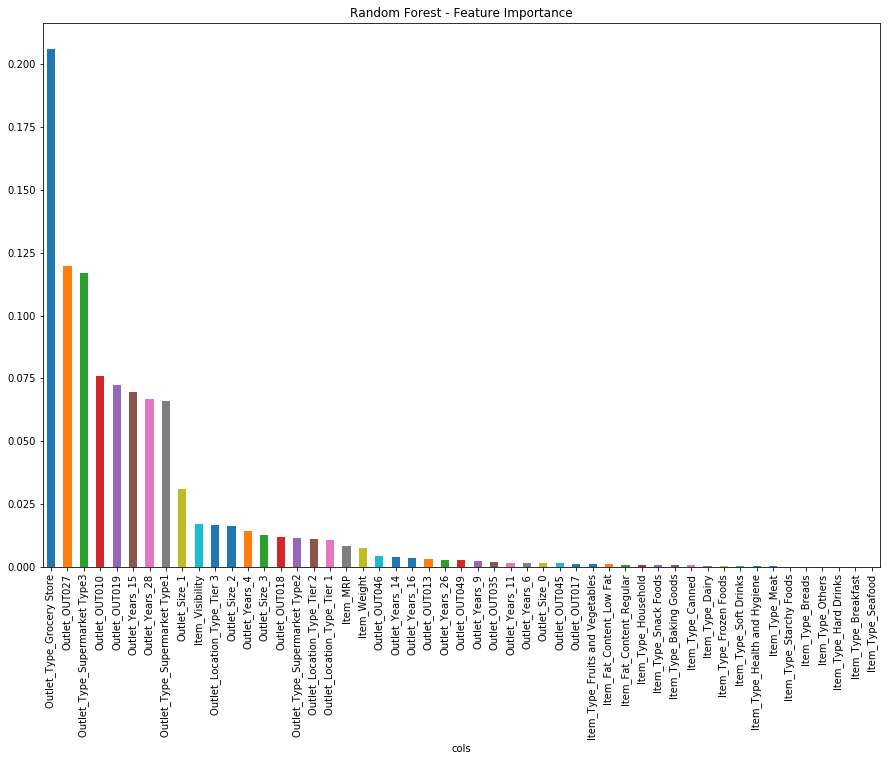

In [50]:
fi[:].plot('cols', 'imp', figsize=(15,10), xticks=fi.index, legend=False, 
           kind='bar',title="Random Forest - Feature Importance")

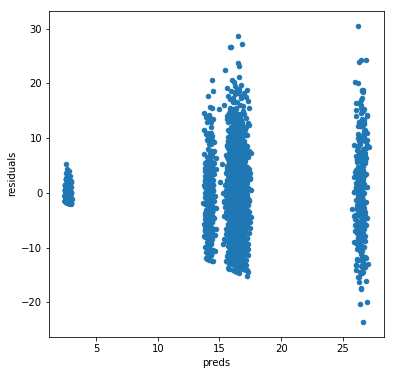

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_rf.fit(X_train, y_train)
preds = pd.DataFrame({"preds":model_rf.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# Interpretation

In [52]:
from pdpbox import pdp
from plotnine import *

In [53]:
# this method is from fast.ai library
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [54]:
def plot_pdp(feat_name, clusters=None):
    p = pdp.pdp_isolate(model_rf, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7feaafc58b38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7feaafc22a20>})

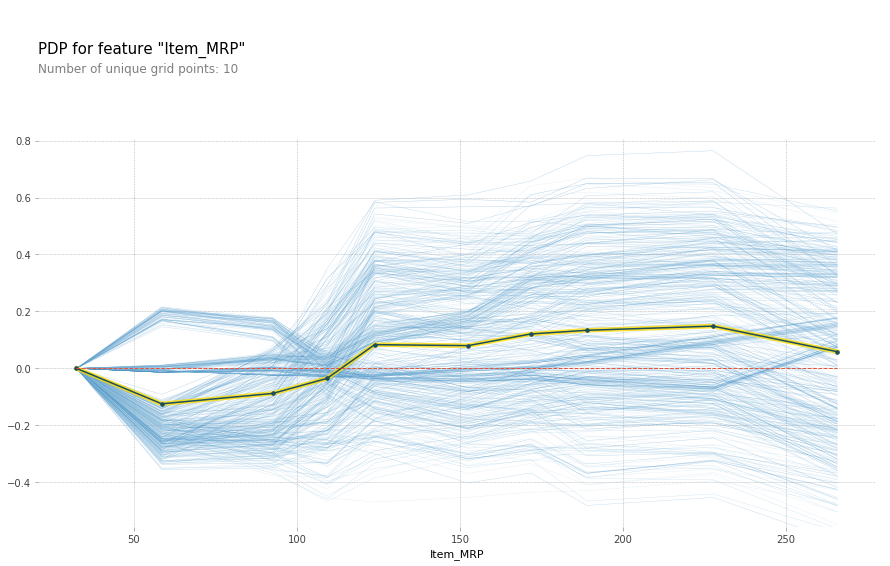

In [55]:
x=get_sample(X,500)
plot_pdp(feat_name='Item_MRP')

#### The above partial dependence plot shows the marginal effect of Item_MRP on the Sales Volumes. MRP has negative effect on sales at the higher end of the price range which is generally expected.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7feaaf6407b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7feaaf69dc18>})

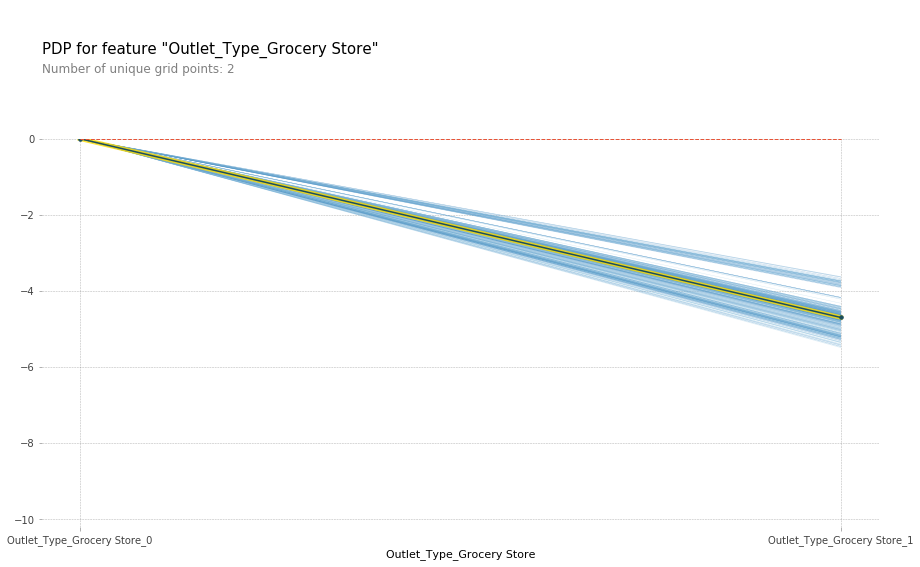

In [56]:
x=get_sample(X,500)
plot_pdp(feat_name='Outlet_Type_Grocery Store')

# Conclusion

* All the models are almost in the same range of RMSE error with RandomForest giving slighlty better result
* The residual plot is having a pattern indicating that the model did not fit the data completely. 
* This needs to be further investigated